In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# pip install -U scikit-learn #-> to update sklearn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.24.1)


**Data preparation** is one of the essential processes in machine learning projects workflow: with well-prepared input even simple algorithm can achieve great result, and without it --- it’s hard to get something meaningful even using the most sophisticated models (remember concept of "[garbage in — garbage out](https://en.wikipedia.org/wiki/Garbage_in,_garbage_out)").

Usually, specific preparation of data for ML modeling can be considered as part of [ETL](https://en.wikipedia.org/wiki/Extract,_transform,_load) process and consists of following steps:

* **feature engineering**: transformation of raw data into proper features, that can be useful for modeling; sometimes, when original data is complex enough (e. g. text, images) this process is also called *feature extraction, feature preparation*.
* **feature selection**: removing unnecessary features (usually it can help to improve model quality/performance/etc).


In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV #, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes

# Graphics in Retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina' 

%matplotlib inline

In [152]:
plt.style.use('seaborn-darkgrid')

In [153]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y)
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

# Feature Engineering

## Missing Values Preprocessing

In [5]:
# path to the df in GDrive
housing_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RS_School/ml-intro-2021/ml-intro-2021/' \
                   '4_feature_engineering_selection/Melbourne_housing_FULL.csv')

In [ ]:
# Checking the amount of NaN's and not NaN's
housing_data.Price.notnull().sum(), housing_data.Price.isnull().sum()

(27247, 7610)

In [6]:
#housing_data = pd.read_csv('Melbourne_housing_FULL.csv')

# deleting Price column from the dataset 
# preparing for the regression task ? 
housing_data = housing_data[~housing_data['Price'].isnull()]

Missing values are one of the most common problems you can encounter when you try to prepare your data for machine learning. The reason for the missing values might be human errors, interruptions in the data flow, privacy concerns, and so on. Whatever is the reason, missing values affect the performance of the machine learning models (most of the algorithms do not even accept datasets with missing values).

First let's check the amount of missing value in each column of our dataset:

In [9]:
housing_data.isnull().mean() # housing_data.isnull().sum() to get absolute numbers

Suburb           0.000000
Address          0.000000
Rooms            0.000000
Type             0.000000
Price            0.000000
Method           0.000000
SellerG          0.000000
Date             0.000000
Distance         0.000037
Postcode         0.000037
Bedroom2         0.236393
Bathroom         0.236613
Car              0.250450
Landsize         0.340037
BuildingArea     0.608911
YearBuilt        0.556502
CouncilArea      0.000110
Lattitude        0.229530
Longtitude       0.229530
Regionname       0.000110
Propertycount    0.000110
dtype: float64

In [10]:
housing_data.isnull().sum() # to get absolute numbers

Suburb               0
Address              0
Rooms                0
Type                 0
Price                0
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          6441
Bathroom          6447
Car               6824
Landsize          9265
BuildingArea     16591
YearBuilt        15163
CouncilArea          3
Lattitude         6254
Longtitude        6254
Regionname           3
Propertycount        3
dtype: int64

In [14]:
# Another way to combine % and actual number of missing values in one code cell
from tabulate import tabulate

top = 15
print(tabulate(
    sorted(list(zip(housing_data.columns, housing_data.isnull().sum(), housing_data.isnull().sum() / housing_data.shape[0] * 100)), key=lambda x: -x[2])[:top], 
    headers=['col_name', 'null_cnt', 'null_perc']))

col_name         null_cnt    null_perc
-------------  ----------  -----------
BuildingArea        16591  60.8911
YearBuilt           15163  55.6502
Landsize             9265  34.0037
Car                  6824  25.045
Bathroom             6447  23.6613
Bedroom2             6441  23.6393
Lattitude            6254  22.953
Longtitude           6254  22.953
CouncilArea             3   0.0110104
Regionname              3   0.0110104
Propertycount           3   0.0110104
Distance                1   0.00367013
Postcode                1   0.00367013
Suburb                  0   0
Address                 0   0


In [15]:
# The shape of the dataset
housing_data.shape

(27247, 21)

In [16]:
# Printing the number of columns alongside with their names 
[i for i in enumerate(housing_data.columns)]

[(0, 'Suburb'),
 (1, 'Address'),
 (2, 'Rooms'),
 (3, 'Type'),
 (4, 'Price'),
 (5, 'Method'),
 (6, 'SellerG'),
 (7, 'Date'),
 (8, 'Distance'),
 (9, 'Postcode'),
 (10, 'Bedroom2'),
 (11, 'Bathroom'),
 (12, 'Car'),
 (13, 'Landsize'),
 (14, 'BuildingArea'),
 (15, 'YearBuilt'),
 (16, 'CouncilArea'),
 (17, 'Lattitude'),
 (18, 'Longtitude'),
 (19, 'Regionname'),
 (20, 'Propertycount')]

The most simple strategy is to drop entire rows and/or columns containing missing values based on some threshold (for example, if column contains more than *30%* --- drop it, then drop all rows that still contains some NaN's).

In [ ]:
threshold = 0.3
housing_data_dropped = housing_data[housing_data.columns[housing_data.isnull().mean() < threshold]]
housing_data_dropped = housing_data_dropped.dropna(axis=0, how='any') # params is optinal here (matching defaults)

print(f'Original dataset shape (rows, cols): {housing_data.shape}')
print(f'Dataset shape (rows, cols) after dropna: {housing_data_dropped.shape}')

Original dataset shape (rows, cols): (27247, 21)
Dataset shape (rows, cols) after dropna: (20401, 18)


In general dropping data without additional investigation is not a good approach in most cases since you lose a lot of potentially useful information. For this particular dataset we've fully dropped `Landsize`, `BuildingArea` columns (which actually seem like strong features from common sense). 

Usually a better strategy is to impute the missing values, i.e., to infer them from the known part of the data. However, there is an important selection of what you impute to the missing values. You can use default value of missing values in the column. For example, if you have a column that only has `1` and `N\A`, then it is likely that the `N\A` rows may be considered as `0`. 
Another way is to use basic statistics (like *mean* and *medians* of the columns) for imputation.

In [17]:
# const imputing
housing_data_const = housing_data.fillna(value=0)

# mean imputing
housing_data_mean = housing_data.fillna(housing_data.mean())

There are also some advanced technics [KNN Imputation](), [Multivariate imputation]().

But commonly the most beneficial way is to dig deeper in available data, understand root cases of the problem and develop mixed strategy (for separate features based on investigation results). **Subject matter expertise rules!**

For example, one of the questions you may ask yourself to help figure this out is this: 

`Is this value missing because it wasn't recorded or because it doesn’t exist?`

If the value is missing because it doesn’t exist (like the height of the oldest child of someone who doesn't have any children) then it doesn't make sense to try and guess what it might be. These values you probably do want to mark this value using some special tag (or create separate bool feature). On the other hand, if a value is missing because it wasn't recorded, then you may probably use some of the imputation technics mentioned above or even more sophisticated ones.


## Feature scaling

In [1]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']
wine_data

NameError: ignored

In [33]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In real world datasets you can often see multiple features spanning varying degrees of magnitude, range, and units. This is a significant obstacle as a lot of machine learning algorithms are highly sensitive to such things.

To make it simple: algorithm just sees number and does not know what that number represents --- if there is a vast difference in the range say few ranging in thousands and few ranging in dozens, it makes the underlying assumption that higher ranging numbers have superiority of some sort. So, these more significant number starts playing a more decisive role while training the model.

For example, you might be looking at the prices of some products in both Yen and US Dollars. One US Dollar is worth about 100 Yen, but if you don't scale your prices methods like SVM or KNN will consider a difference in price of 1 Yen as important as a difference of 1 US Dollar! This clearly doesn't fit with our intuitions of the world. With currency, you can convert between currencies. But what about if you're looking at something like height and weight? It's not entirely clear how many pounds should equal one inch (or how many kilograms should equal one meter).

By scaling your variables, you can help compare different variables on equal footing (scale).

### Standartization

**Standardization** of datasets is a common requirement for many machine learning models. The idea is to transform the data to the center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.

$$scaled\_X = \frac{X - mean(X)}{std(X)}$$, where $X$ is **feature column** (not dataset itself!)

A common approach is to use `StandardScaler` from `sklearn`:


In [35]:
scaler = StandardScaler()
wine_data_scaled = scaler.fit_transform(wine_data)
wine_data_scaled

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

Let's illustrate the influence of scaling on [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis):

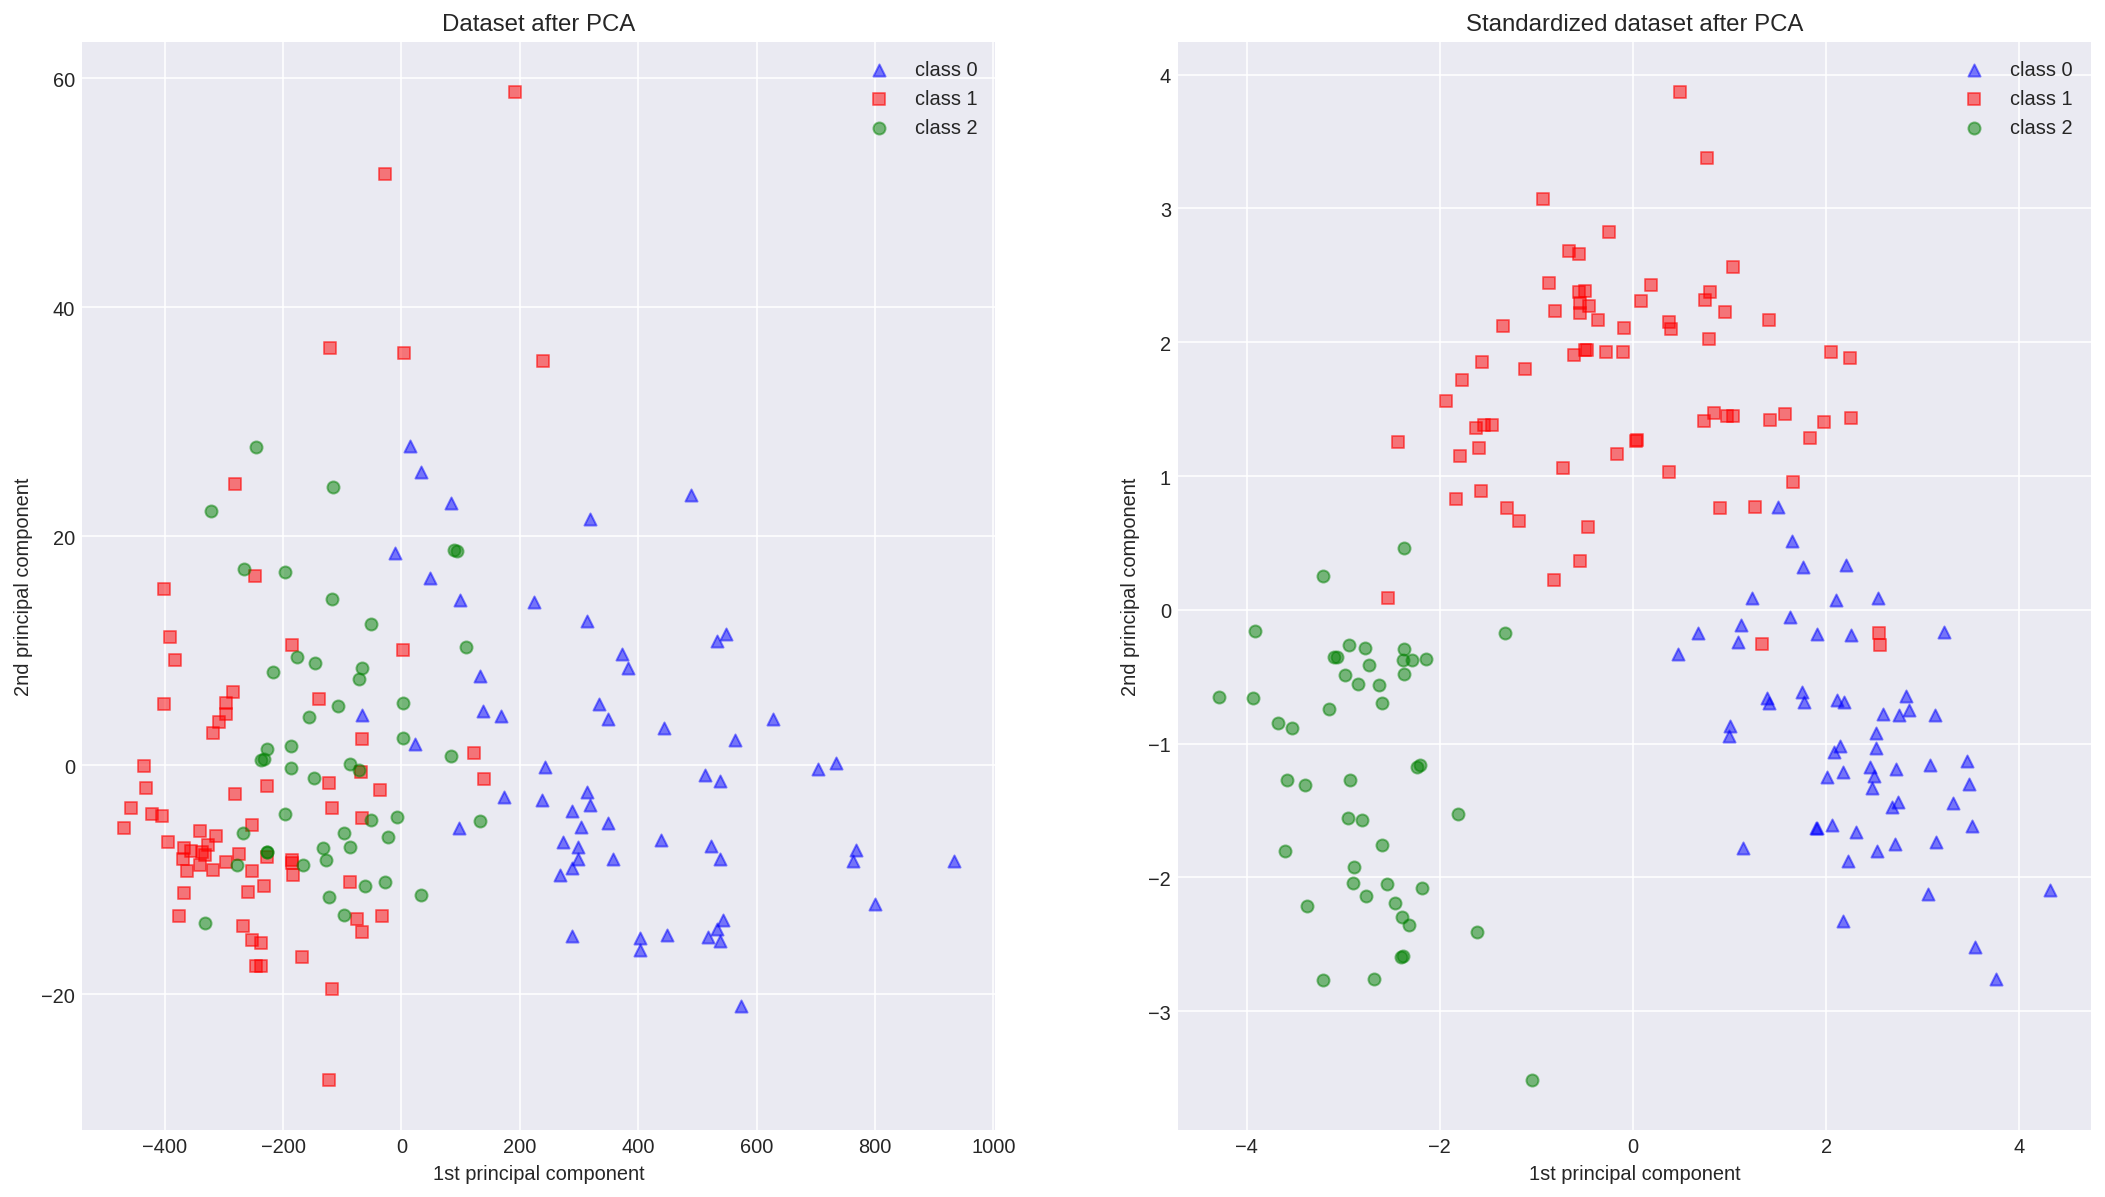

In [38]:
pca = PCA(n_components=2)

wine_data_pca = pca.fit_transform(wine_data)
wine_data_scaled_pca = pca.fit_transform(wine_data_scaled)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 10))

for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax1.scatter(wine_data_pca[wine_labels == l, 0], wine_data_pca[wine_labels == l, 1], 
                color=c, label=f'class {l}', alpha=0.5, marker=m)

for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax2.scatter(wine_data_scaled_pca[wine_labels == l, 0], wine_data_scaled_pca[wine_labels == l, 1], 
                color=c, label=f'class {l}', alpha=0.5, marker=m)
    
ax1.set_title('Dataset after PCA')
ax2.set_title('Standardized dataset after PCA')

for ax in (ax1, ax2):
    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.legend(loc='upper right')

### Normalization

An alternative standardization is scaling features to lie between a given minimum and maximum value, often between zero and one, or so that the maximum absolute value of each feature is scaled to unit size (also known as **Normalization**.  This can be achieved using `MinMaxScaler` or `MaxAbsScaler` from `sklearn`, respectively.

The motivation to use this scaling include robustness to very small standard deviations of features and preserving zero entries in sparse data.

$$normalised\_X = \frac{X - min(X)}{max(X) - min(X)}$$, where $X$ is **feature column** (not dataset itself!)

In [42]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit_transform(wine_data)

array([[0.84210526, 0.1916996 , 0.57219251, ..., 0.45528455, 0.97069597,
        0.56134094],
       [0.57105263, 0.2055336 , 0.4171123 , ..., 0.46341463, 0.78021978,
        0.55064194],
       [0.56052632, 0.3201581 , 0.70053476, ..., 0.44715447, 0.6959707 ,
        0.64693295],
       ...,
       [0.58947368, 0.69960474, 0.48128342, ..., 0.08943089, 0.10622711,
        0.39728959],
       [0.56315789, 0.36561265, 0.54010695, ..., 0.09756098, 0.12820513,
        0.40085592],
       [0.81578947, 0.66403162, 0.73796791, ..., 0.10569106, 0.12087912,
        0.20114123]])

## Log/Power Transform

Log transformation is a data transformation method in which it replaces each variable $x$ with a $log(x)$. The choice of the logarithm base is usually left up to the analyst and it would depend on the purposes of statistical modeling.

When our original continuous data do not follow the bell curve, we can log transform this data to make it as “normal” as possible so that the statistical analysis results from this data become more valid. In other words, the log transformation reduces or removes the skewness of our original data. The important caveat here is that the original data has to approximately follow a *log-normal distribution*. Otherwise, you can't expect any guarantees that result distribution will be close to normal (but even in such cases log transform can help to improve you scores).

In [43]:
mu, sigma = 5, 1
lognorm_data = np.random.lognormal(mu, sigma, 1000)

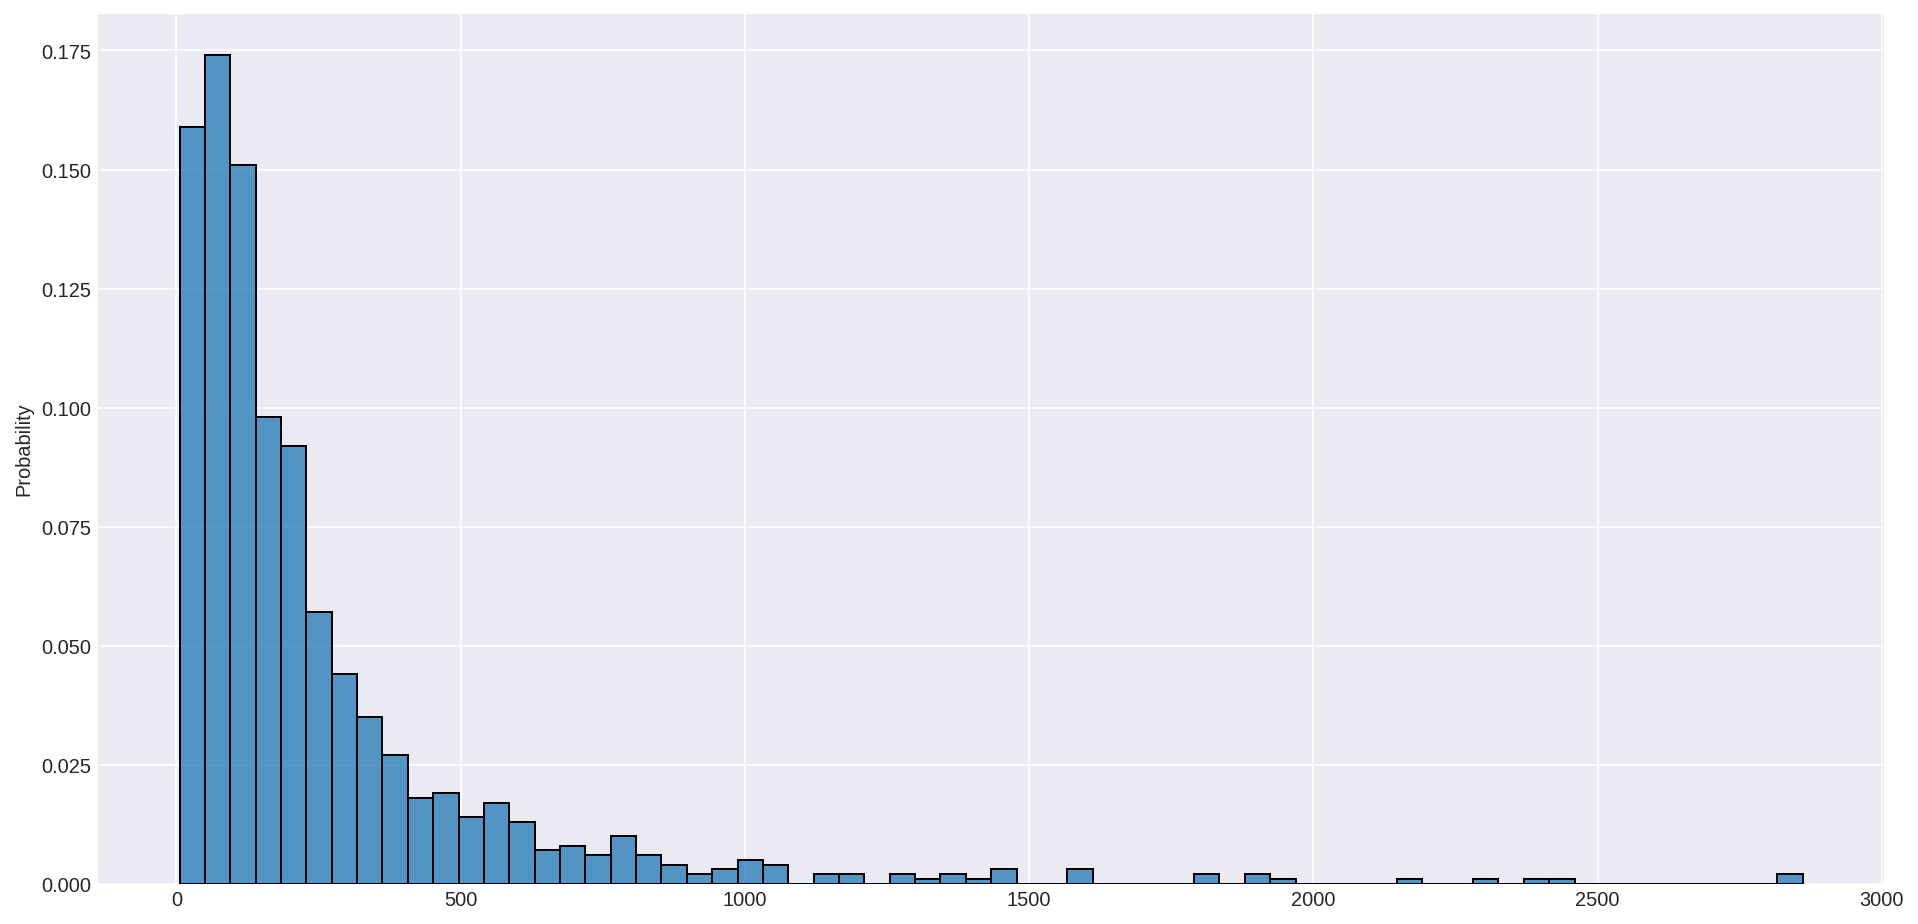

In [44]:
plt.figure(figsize=(16,8))
sns.histplot(lognorm_data, stat='probability')
plt.show()

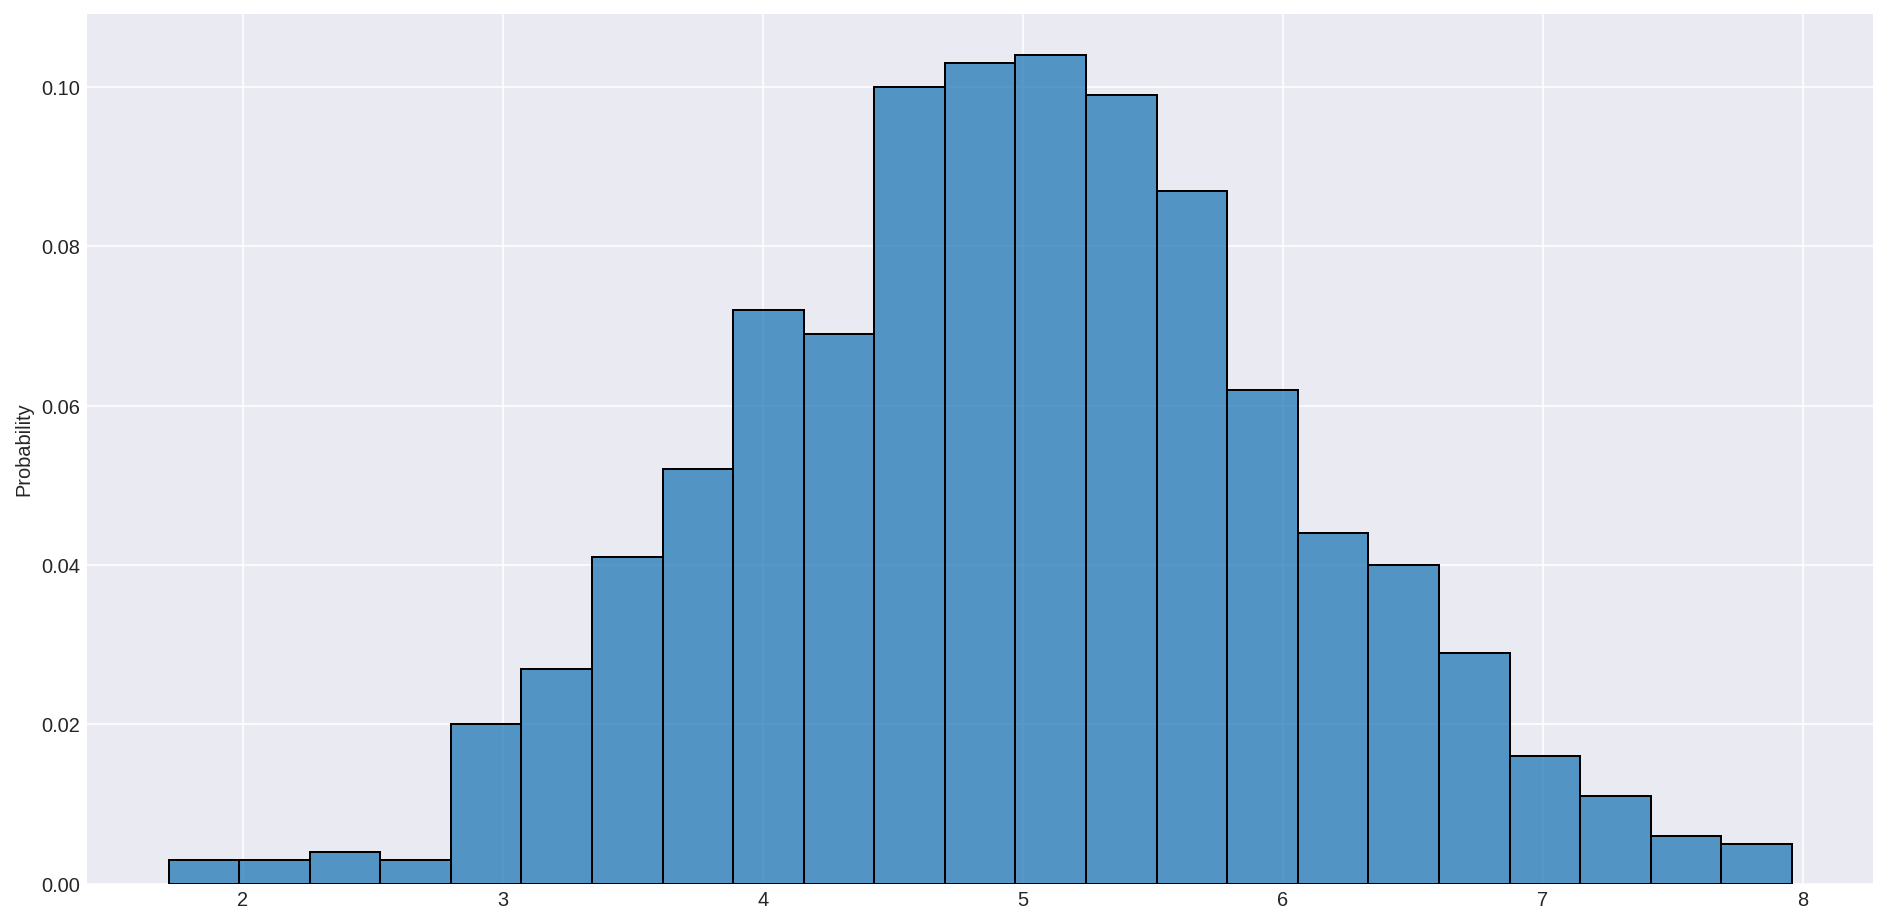

In [45]:
plt.figure(figsize=(16,8))
sns.histplot(np.log(lognorm_data), stat='probability')
plt.show()

This may sound a bit odd: is it even possible to meet something specific like "log-normal distribution" in real life?

Well, let's plot the price column from Melbourne housing dataset, that we used previously:

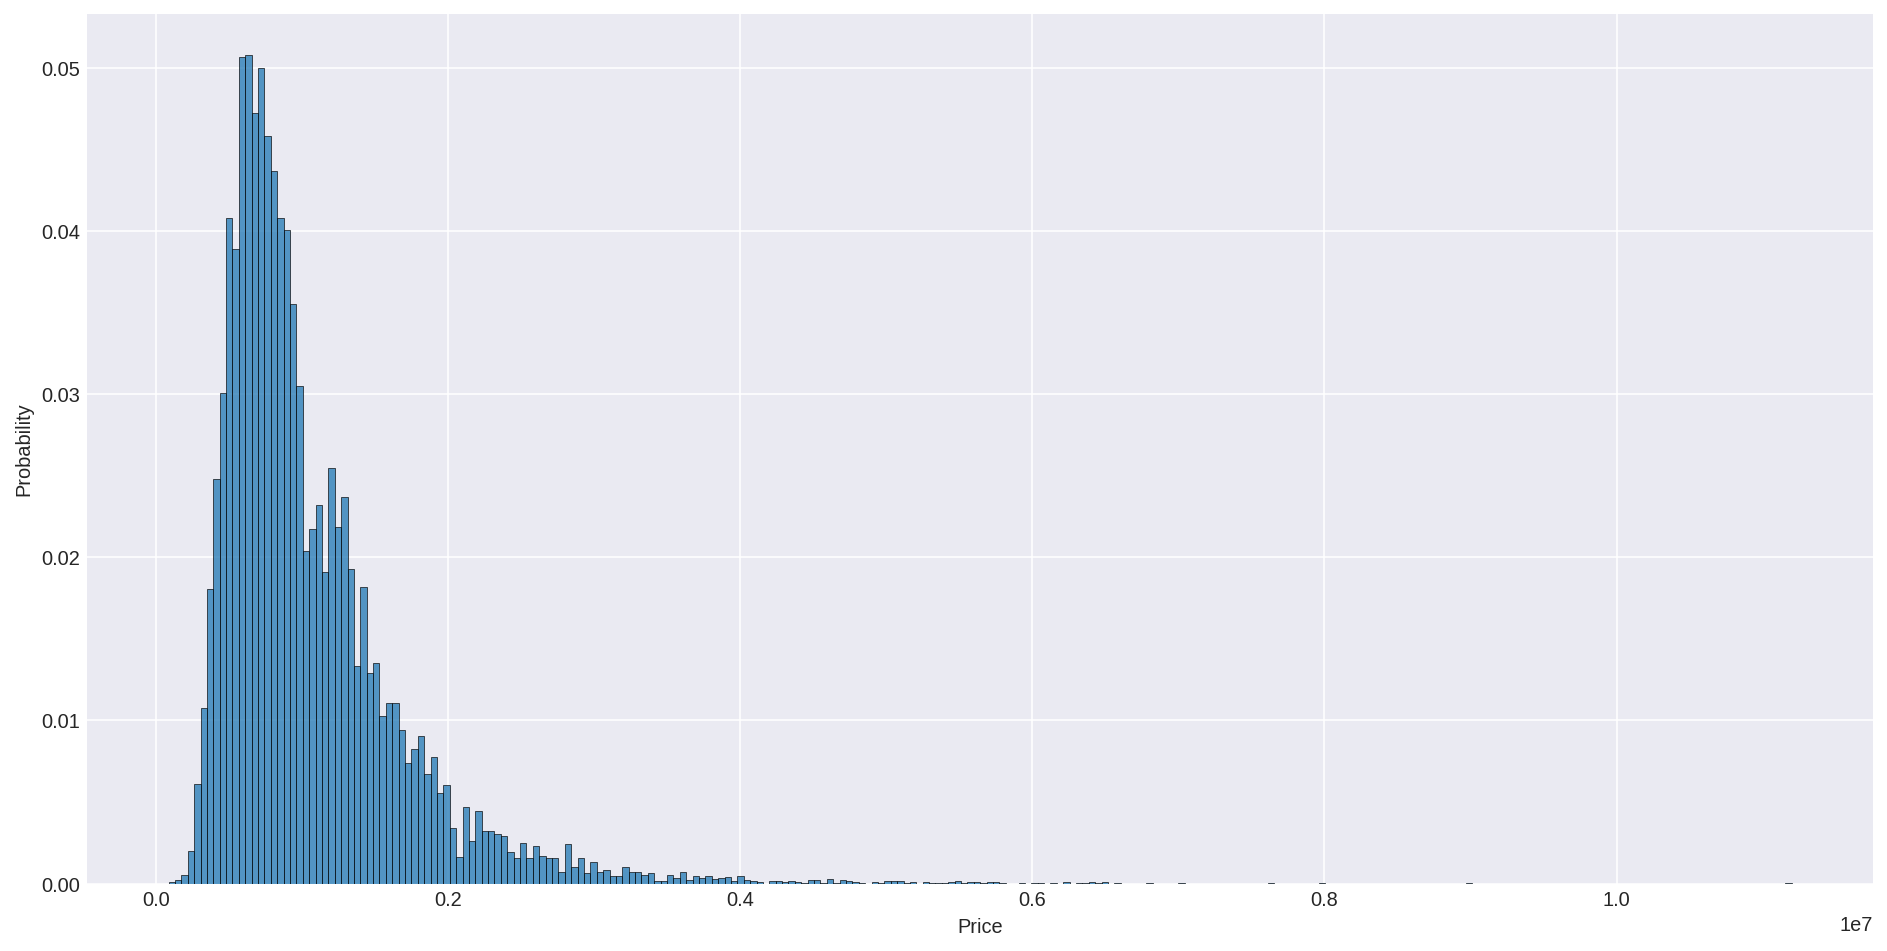

In [57]:
plt.figure(figsize=(16,8))
sns.histplot(housing_data['Price'], stat='probability')
plt.show()

Seems familiar!

Eventually, lognormal distribution of some value in real world is quite common (just like normal distribution). It is suitable for describing length of comments, posted in the internet; the salaries amount; the population of cities and many other things. You may find some [more](https://en.wikipedia.org/wiki/Log-normal_distribution#Occurrence_and_applications) examples just on the wikipedia page.

However, to get some profit from this transformation, the distribution does not necessarily have to be *exactly* lognormal; you can try to apply it to any distribution with a heavy right tail. Furthermore, one can try to use other similar transformations, formulating their own hypotheses on how to approximate the available distribution to a normal. Examples of such transformations are Box-Cox transformation (log is a special case of the Box-Cox transformation) or Yeo-Johnson transformation (extends the range of applicability to negative numbers). Some information about these transformations and their implementations in `sklean` can be found [here](https://scikit-learn.org/stable/modules/preprocessing.html#non-linear-transformation).

## Categorical Features Encoding

Quite often features are not given as continuous values but categorical. For example a person could have features `["male", "female"], ["from Europe", "from US", "from Asia"], ["uses Firefox", "uses Chrome", "uses Safari", "uses Internet Explorer"]`. Such features can be efficiently coded as integers, for instance `["male", "from US", "uses Internet Explorer"]` could be expressed as `[0, 1, 3]` while `["female", "from Asia", "uses Chrome"]` would be `[1, 2, 1]`.

To convert categorical features to such integer codes, we can use the *ordinal encoding*. It transforms each categorical feature to a range of integers (0 to number of categories - 1).

In [58]:
X = [['male', 'US', 'Safari'], ['female', 'Europe', 'Firefox'], ['male', 'Europe', 'Opera']]
pd.DataFrame(X, columns=['gender', 'place', 'browser'])

,gender,place,browser
0,male,US,Safari
1,female,Europe,Firefox
2,male,Europe,Opera


In [60]:
encoder = OrdinalEncoder()
ordinal_encoded_X = encoder.fit_transform(X)
ordinal_encoded_X

array([[1., 1., 2.],
       [0., 0., 0.],
       [1., 0., 1.]])

Such integer representation can, however, can be unsuitable, for a lot of models: these expect continuous input, and would interpret the categories as being ordered, which is often not desired.

Another possibility to convert categorical features to features that can be used with scikit-learn estimators is to use *one-hot* encoding. The idea is to transforms each categorical feature, that has $n$ different possible categories, into $n$ separate binary features (whether the object belongs to specific category or not).

In [61]:
encoder = OneHotEncoder()
ohe_encoded_X = encoder.fit_transform(X).toarray()

In [62]:
pd.DataFrame(ohe_encoded_X, columns=encoder.get_feature_names())

,x0_female,x0_male,x1_Europe,x1_US,x2_Firefox,x2_Opera,x2_Safari
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0


It is also possible to encode each column into  $n - 1$ columns instead of $n$ columns by using the drop parameter (also called *dummy encoding*). This is useful to avoid co-linearity in the input matrix in some classifiers. Such functionality is useful, for example, when using non-regularized regression, since co-linearity would cause the covariance matrix to be non-invertible.

You can read about some advanced technics [here](https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding). However, most of them equivalent to one hot encoding to some degree.


# Feature Selection

Why is it sometimes necessary to select just subset of features and not all at once? The idea of removing features may seem a little counterintuitive, but there is some import motivation here:

1) First is more connected to engeneering side: the more data, the higher the computational complexity. Removing some unimportant and noisy features can help a lot here.    
2) The second reason is related to algorithms side: some models can be unstable when data have highly correlated features ([multicolinearity](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features)), some --- when data is noisy. 

In [66]:
cancer_sklearn = load_breast_cancer(as_frame=True)
cancer_data, cancer_labels = cancer_sklearn['data'], cancer_sklearn['target']
cancer_data_scaled = StandardScaler().fit_transform(cancer_data)
cancer_data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


## Statistical Approaches

The most obvious candidate for removal is a feature whose value remains unchanged, i.e., it contains no information at all. If we build on this thought, it is reasonable to say that features with low variance are worse than those with high variance. So, one can consider cutting features with variance below a certain threshold.

In [67]:
X_generated, y_generated = make_classification(n_samples=1000, n_features=25, n_informative=3,
                                                         n_redundant=2, n_repeated=0)
X_generated.shape

(1000, 25)

In [68]:
print(VarianceThreshold(0.9).fit_transform(X_generated).shape)
print(VarianceThreshold(1).fit_transform(X_generated).shape)
print(VarianceThreshold(1.1).fit_transform(X_generated).shape)

(1000, 24)
(1000, 14)
(1000, 5)


Keep in mind that we are using absolute value as threshold, so in real world scenario it is necessary to bring all the features to same scale (perform scaling before thresholding).

Personally, I won't recommend using `VarianceTreshold` unless you are completely sure that it's needed and won't make things worse: the low variance does not necessarily mean that feature is not informative. You can also try [other](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) a little bit more advanced statistical approaches.

## Selection From Modeling


Basically, the idea is to use some model as an feature importance estimator: for example, we can use linear model with `Lasso` regularization (and feature weights from it) or some tree based models (which have natural ability to compute feature importance). Then, based on received importance/weights we can choose some threshold and take features, that have importance above this value.

In [69]:
selection_model = RandomForestClassifier(random_state=42)
selector = SelectFromModel(selection_model).fit(cancer_data, cancer_labels)
cancer_data_pruned = selector.transform(cancer_data)

print(cancer_data.columns[selector.get_support()])
print(f'Original shape: {cancer_data.shape}')
print(f'Shape after selection: {cancer_data_pruned.shape}')

Index(['mean radius', 'mean perimeter', 'mean area', 'mean concavity',
       'mean concave points', 'worst radius', 'worst perimeter', 'worst area',
       'worst concavity', 'worst concave points'],
      dtype='object')
Original shape: (569, 30)
Shape after selection: (569, 10)


In [70]:
# just experimenting with n_estimators in the RF model
selection_model = RandomForestClassifier(n_estimators = 25, random_state=42)
selector = SelectFromModel(selection_model).fit(cancer_data, cancer_labels)
cancer_data_pruned = selector.transform(cancer_data)

print(cancer_data.columns[selector.get_support()])
print(f'Original shape: {cancer_data.shape}')
print(f'Shape after selection: {cancer_data_pruned.shape}')

Index(['mean radius', 'mean perimeter', 'mean area', 'mean concavity',
       'mean concave points', 'area error', 'worst radius', 'worst perimeter',
       'worst compactness', 'worst concavity', 'worst concave points'],
      dtype='object')
Original shape: (569, 30)
Shape after selection: (569, 11)


In [74]:
#pip install catboost

     |████████████████████████████████| 65.8MB 102kB/s 


In [81]:
# Checking with CatBoost
from catboost import CatBoostClassifier


selection_model = CatBoostClassifier(task_type = 'CPU', early_stopping_rounds = 10, 
                                     random_state=42,verbose=0)

selector = SelectFromModel(selection_model).fit(cancer_data, cancer_labels)
cancer_data_pruned = selector.transform(cancer_data)

print(cancer_data.columns[selector.get_support()])
print(f'Original shape: {cancer_data.shape}')
print(f'Shape after selection: {cancer_data_pruned.shape}')

Index(['mean texture', 'mean concave points', 'area error', 'worst radius',
       'worst texture', 'worst perimeter', 'worst area', 'worst smoothness',
       'worst concavity', 'worst concave points'],
      dtype='object')
Original shape: (569, 30)
Shape after selection: (569, 10)


In [82]:
main_model = LogisticRegression(solver='liblinear', penalty='l1')
pipe_baseline = make_pipeline(StandardScaler(), main_model)
pipe_selection = make_pipeline(StandardScaler(), SelectFromModel(selection_model), main_model) # fix to select only once

print('Result on original data: {:f}'.format(cross_val_score(pipe_baseline, cancer_data, cancer_labels, 
                      scoring='accuracy', cv=5).mean()))

print('Result after selection {:f}'.format(cross_val_score(pipe_selection, cancer_data, cancer_labels, 
                      scoring='accuracy', cv=5).mean()))

Result on original data: 0.970160
Result after selection 0.966620


**Note from the original notebook.** We were able to reduce the number of features significantly, but, as you can see, stable performance is not guaranteed. 

**My Note.** After using CatBoost as a Model Selection param and the model for training itself - the results are quite promising.

It's also possible to use same model as an importance estimator and actual classifier (regressor).
As a development of this approach we can consider recursive feature elimination: first, the model is trained on the initial set of features and the importance of each feature is obtained. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [83]:
min_features_to_select = 1 
rfecv = RFECV(estimator=selection_model, step=1, cv=KFold(3), 
              scoring='accuracy', min_features_to_select=min_features_to_select)
rfecv.fit(cancer_data_scaled, cancer_labels)

print("Optimal number of features : %d" % rfecv.n_features_)


Optimal number of features : 14


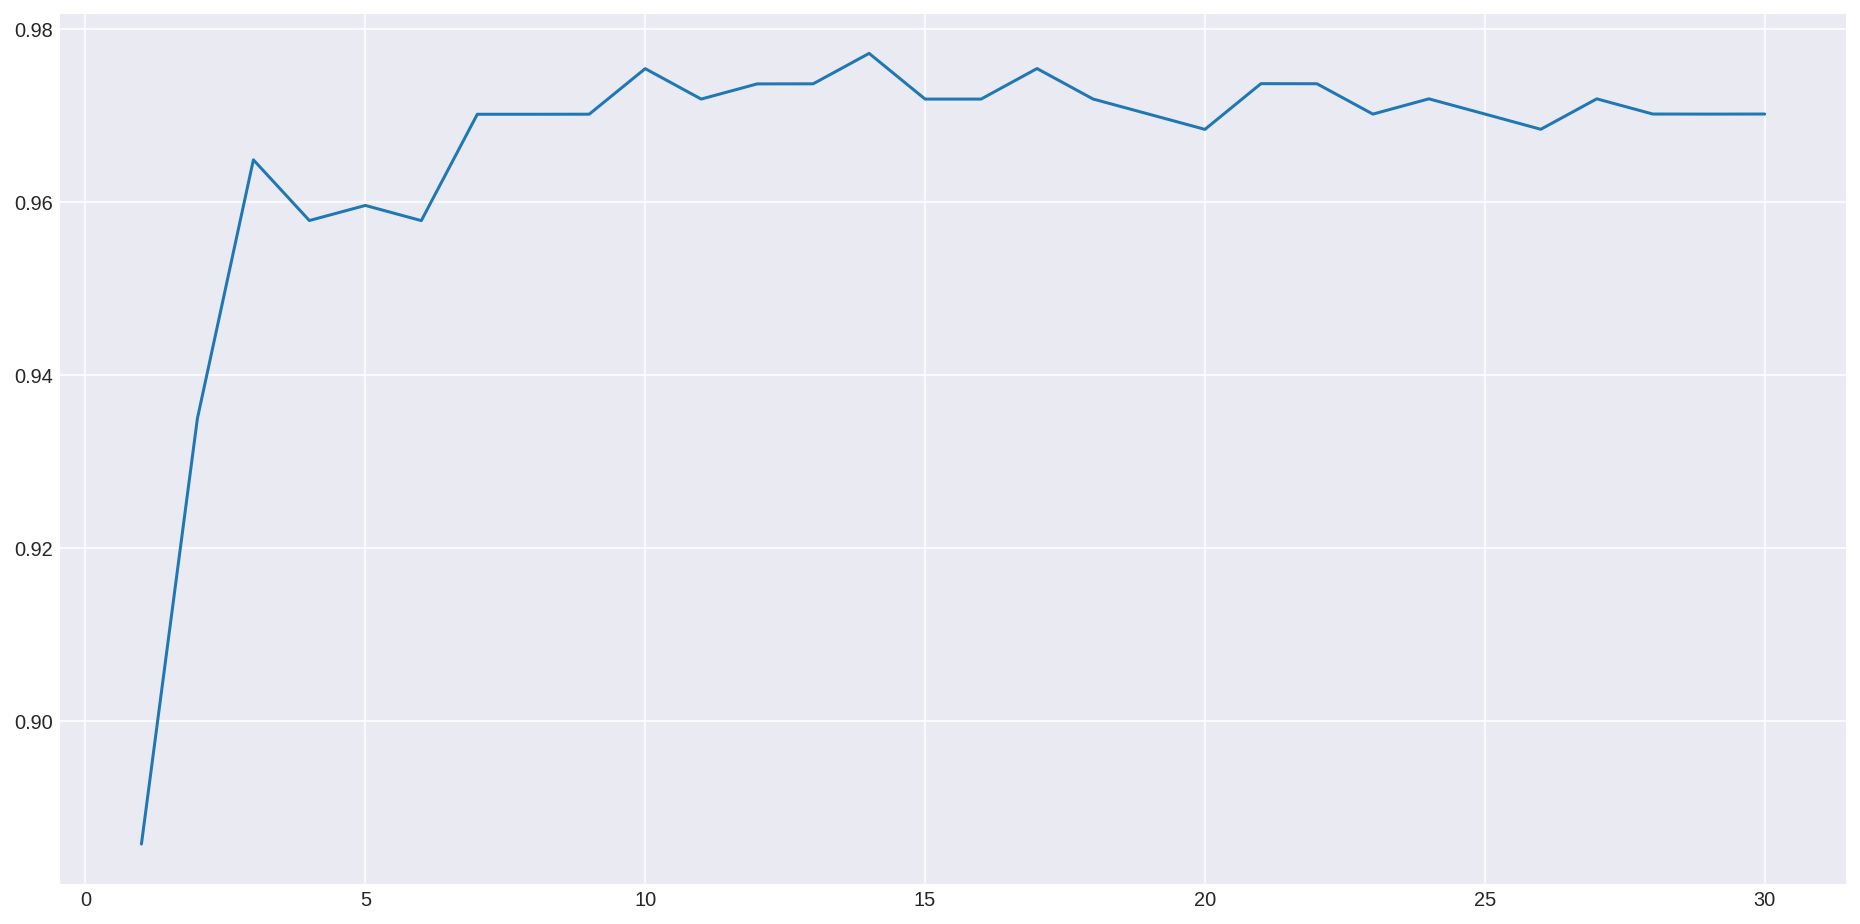

In [84]:
plt.figure(figsize=(16,8))
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

## Greedy (Sequential) Feature Selection 

Finally, we get to the most reliable method --- trivial brute force: just test all possible subsets of features (train a model on a subset of features, store results, repeat for different subsets, and compare the quality of models to identify the best feature set). This approach is called [Exhaustive Feature Selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector).

However, usually this method is too computationally complex to use for some real word dataset (it's even not available in scikit-learn). To reduce complexity one can the following *greedy* heuristic:  tart with zero feature and find the one feature that maximizes a cross-validated score when the model is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. It is possible to iterate until we hit (preselected) maximum number of features or until the quality of the model ceases to increase significantly between iterations.

This algorithm can work in the opposite direction: instead of starting with no feature and greedily adding features, we start with all the features and greedily remove features from the set.

In [ ]:
selector = SequentialFeatureSelector(main_model, scoring='accuracy', n_jobs=-1).fit(cancer_data_scaled, cancer_labels)
cancer_data_scaled_pruned = selector.transform(cancer_data_scaled)

print(cancer_data.columns[selector.get_support()])
print(f'Original shape: {cancer_data.shape}')
print(f'Shape after selection: {cancer_data_pruned.shape}\n')

print('Result on original data: {:f}'.format(cross_val_score(main_model, cancer_data_scaled, 
                                                           cancer_labels, scoring='accuracy', cv=5).mean()))

print('Result after selection {:f}'.format(cross_val_score(main_model, cancer_data_scaled_pruned, 
                                                        cancer_labels, scoring='accuracy', cv=5).mean()))

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean concavity', 'mean concave points',
       'texture error', 'smoothness error', 'concavity error',
       'symmetry error', 'worst radius', 'worst texture', 'worst perimeter',
       'worst smoothness'],
      dtype='object')
Original shape: (569, 30)
Shape after selection: (569, 10)

Result on original data: 0.975423
Result after selection 0.980686


# Homework

## Exercise  1 - Scaling (3 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

1) 1.5 points is for correct wine dataset standardization and another 1.5 points is for implementation of standardization function, that is working in more general case.

2) "General case" doesn't mean, that you need to handle some/all really "specific" cases (datasets with missing/categorial variables, very large dataset, etc). Let's assume that it should work with numeric datasets of reasonable shape: showing the output for one or two randomly generated 10x10 dataset and comparing the results with `StandardScaler` should be enough (or you can be more creative).



In [123]:
# loading the dataset
wine_sklearn = load_wine(as_frame=True) # need to have sklearn => version 0.23 
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']
wine_data

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [124]:
# tranforming DF so all values == float64
wine_data.astype('float64')

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [125]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In [126]:
## your code

# stadartization of the data 
custom_scaled_data = (wine_data - np.mean(wine_data, axis=0)) / np.std(wine_data, axis=0)

In [127]:
custom_scaled_data

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.876275,2.974543,0.305159,0.301803,-0.332922,-0.985614,-1.424900,1.274310,-0.930179,1.142811,-1.392758,-1.231206,-0.021952
174,0.493343,1.412609,0.414820,1.052516,0.158572,-0.793334,-1.284344,0.549108,-0.316950,0.969783,-1.129518,-1.485445,0.009893
175,0.332758,1.744744,-0.389355,0.151661,1.422412,-1.129824,-1.344582,0.549108,-0.422075,2.224236,-1.612125,-1.485445,0.280575
176,0.209232,0.227694,0.012732,0.151661,1.422412,-1.033684,-1.354622,1.354888,-0.229346,1.834923,-1.568252,-1.400699,0.296498


In [136]:
# Transforming Pandas DF to Numpy array
custom_scaled_data = np.asarray(custom_scaled_data)
custom_scaled_data

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

In [128]:
# Comapring with StandardScaler

# loading the dataset
wine_sklearn = load_wine(as_frame=True) # need to have sklearn => version 0.23 
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']
wine_data.astype('float64')

# intializing the StandardScaler
sc = StandardScaler()
sc_scaled_data = sc.fit_transform(wine_data)
sc_scaled_data

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

In [137]:
# Checking the shape 
custom_scaled_data.shape, sc_scaled_data.shape

((178, 13), (178, 13))

In [138]:
# Checking the type 
type(custom_scaled_data), type(sc_scaled_data)

(numpy.ndarray, numpy.ndarray)

In [149]:
# A brief comparison between two scaled datasets
custom_scaled_data == sc_scaled_data

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

(array([[ 0.,  1., 18., 45., 43., 48., 21.,  2.,  0.,  0.],
        [ 0.,  0.,  4., 82., 39., 24., 20.,  6.,  3.,  0.],
        [ 1.,  4., 15., 31., 66., 40., 18.,  1.,  2.,  0.],
        [ 0.,  5.,  9., 39., 63., 40., 17.,  4.,  1.,  0.],
        [ 0.,  1.,  9., 55., 59., 33., 14.,  5.,  0.,  2.],
        [ 0.,  1., 21., 47., 37., 53., 16.,  3.,  0.,  0.],
        [ 0.,  0., 31., 31., 41., 54., 20.,  0.,  1.,  0.],
        [ 0.,  0., 12., 63., 42., 33., 20.,  8.,  0.,  0.],
        [ 0.,  0., 19., 34., 64., 39., 13.,  7.,  2.,  0.],
        [ 0.,  0., 10., 60., 57., 28., 14.,  7.,  2.,  0.],
        [ 0.,  1., 23., 30., 49., 49., 23.,  2.,  1.,  0.],
        [ 0.,  0., 30., 29., 40., 59., 19.,  1.,  0.,  0.],
        [ 0.,  0.,  8., 63., 52., 28., 20.,  6.,  1.,  0.]]),
 array([-3.67916223, -2.8741088 , -2.06905536, -1.26400192, -0.45894848,
         0.34610495,  1.15115839,  1.95621183,  2.76126526,  3.5663187 ,
         4.37137214]),
 <a list of 13 Lists of Patches objects>)

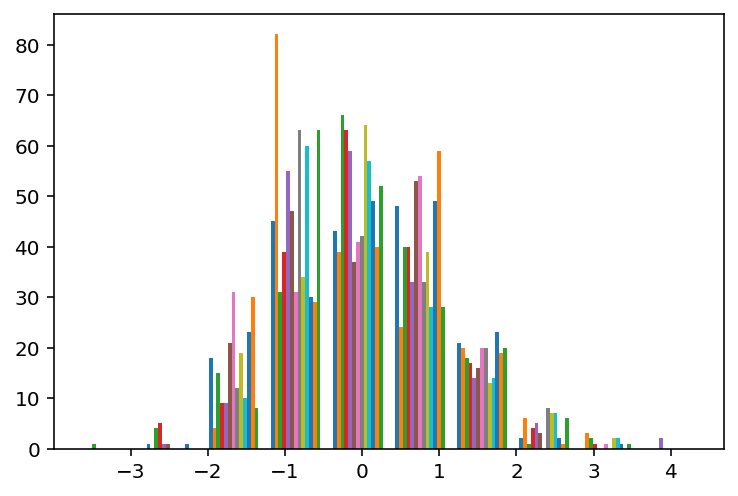

In [150]:
# Viz of custom_scaled_data
plt.hist(custom_scaled_data)

(array([[ 0.,  1., 18., 45., 43., 48., 21.,  2.,  0.,  0.],
        [ 0.,  0.,  4., 82., 39., 24., 20.,  6.,  3.,  0.],
        [ 1.,  4., 15., 31., 66., 40., 18.,  1.,  2.,  0.],
        [ 0.,  5.,  9., 39., 63., 40., 17.,  4.,  1.,  0.],
        [ 0.,  1.,  9., 55., 59., 33., 14.,  5.,  0.,  2.],
        [ 0.,  1., 21., 47., 37., 53., 16.,  3.,  0.,  0.],
        [ 0.,  0., 31., 31., 41., 54., 20.,  0.,  1.,  0.],
        [ 0.,  0., 12., 63., 42., 33., 20.,  8.,  0.,  0.],
        [ 0.,  0., 19., 34., 64., 39., 13.,  7.,  2.,  0.],
        [ 0.,  0., 10., 60., 57., 28., 14.,  7.,  2.,  0.],
        [ 0.,  1., 23., 30., 49., 49., 23.,  2.,  1.,  0.],
        [ 0.,  0., 30., 29., 40., 59., 19.,  1.,  0.,  0.],
        [ 0.,  0.,  8., 63., 52., 28., 20.,  6.,  1.,  0.]]),
 array([-3.67916223, -2.8741088 , -2.06905536, -1.26400192, -0.45894848,
         0.34610495,  1.15115839,  1.95621183,  2.76126526,  3.5663187 ,
         4.37137214]),
 <a list of 13 Lists of Patches objects>)

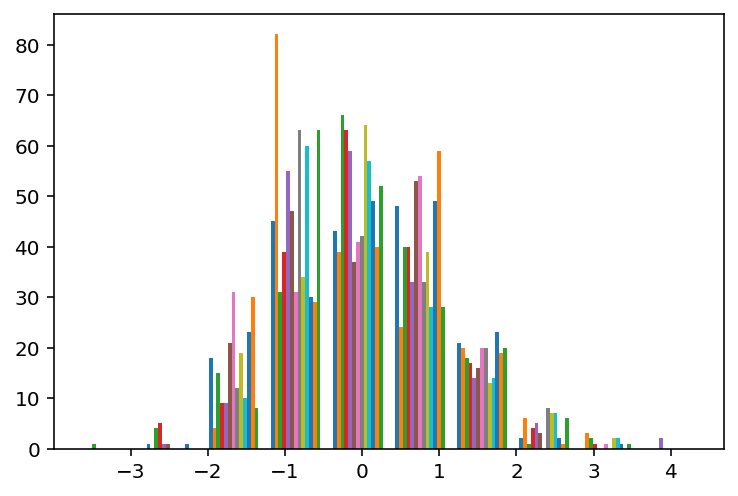

In [151]:
# Viz of sc_scaled_data
plt.hist(sc_scaled_data)

## Exercise  2 - Visualization (4 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [81]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[-1.7794632 , -1.66995524],
       [ 8.13261746,  1.79591802],
       [ 0.48664572,  1.41658547],
       ...,
       [-0.9413198 ,  7.44167087],
       [16.63925835,  4.41300126],
       [12.45770637,  5.31980553]])

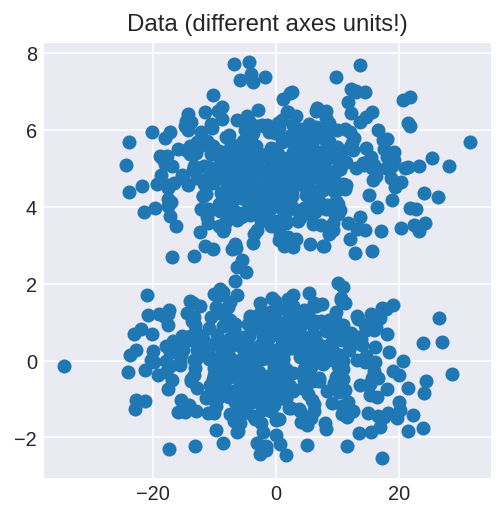

In [154]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

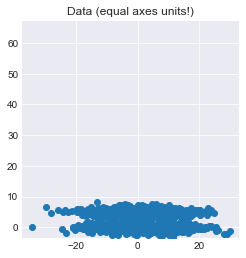

In [ ]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (1 point)

In [91]:
from sklearn.preprocessing import MinMaxScaler

# loading the dataset
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])

# initializing the scaler 
sc = MinMaxScaler()

# fit tranform the dataset 
minmax_scaled_data= sc.fit_transform(data)

In [92]:
minmax_scaled_data

array([[0.4553139 , 0.30750827],
       [0.42469855, 0.23486579],
       [0.5752762 , 0.29142332],
       ...,
       [0.47530851, 0.74495115],
       [0.53782586, 0.74353657],
       [0.52910355, 0.55046217]])

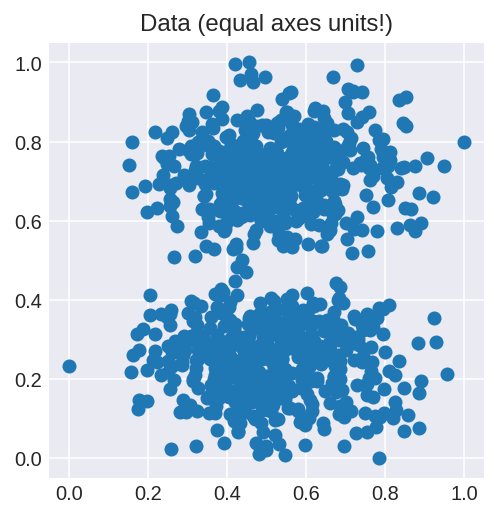

In [155]:
plot_scatter(minmax_scaled_data[:, 0], minmax_scaled_data[:, 1], 
             auto_scaled=False, title='Data (equal axes units!)')

### StandardScaler (1 point)

In [156]:
from sklearn.preprocessing import StandardScaler

# loading the dataset
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])

# initializing the scaler 
sc = StandardScaler()

# fit tranform the dataset 
sc_scaled_data= sc.fit_transform(data)

In [157]:
sc_scaled_data

array([[-1.25516023, -1.36924291],
       [ 0.21394045, -0.43018124],
       [ 0.86645718, -0.9618285 ],
       ...,
       [ 0.99695686,  0.20523397],
       [-0.41815883,  1.06373522],
       [ 1.0236265 ,  0.97090244]])

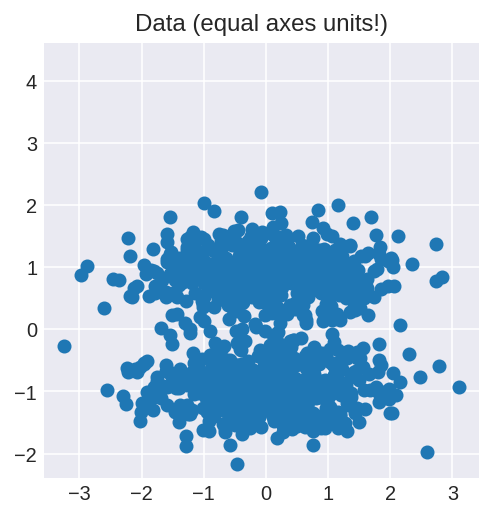

In [158]:
plot_scatter(sc_scaled_data[:, 0], sc_scaled_data[:, 1], 
             auto_scaled=False, title='Data (equal axes units!)')

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


In [160]:
from sklearn.cluster import KMeans

# loading the dataset
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])

# model initialization 
model = KMeans(n_clusters=2)

# fitting the model
model.fit(data)

KMeans(n_clusters=2)

In [163]:
# Checking the centroids 
model.cluster_centers_

array([[ 8.8514448 ,  2.61812787],
       [-7.09463549,  2.35871101]])

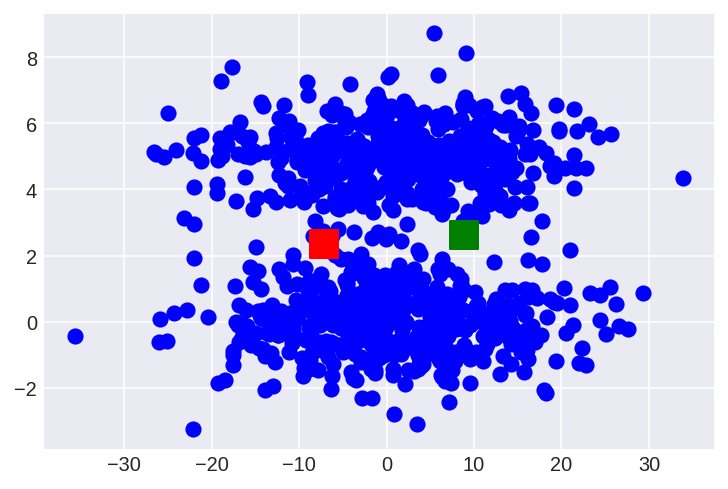

In [166]:
# Viz - 1
plt.scatter(data[ : , 0], data[ : , 1], s =50, c='b')
plt.scatter(8.8514448, 2.61812787, s=200, c='g', marker='s')
plt.scatter(-7.09463549, 2.35871101, s=200, c='r', marker='s')
plt.show()

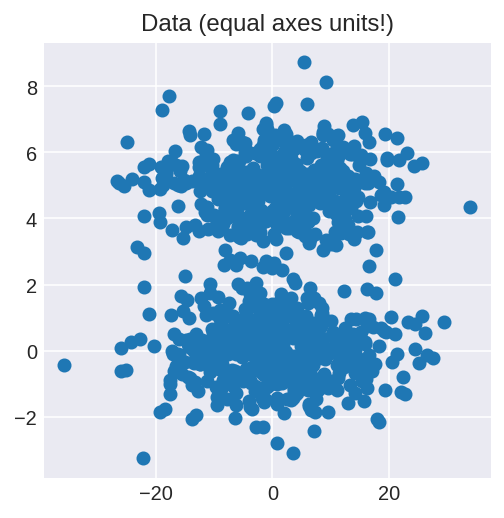

In [168]:
# Viz - 2
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True , title='Data (equal axes units!)')

In [170]:
## scaled example

from sklearn.preprocessing import StandardScaler

# loading the dataset
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])

# initializing the scaler 
sc = StandardScaler()

# fit tranform the dataset 
sc_scaled_data= sc.fit_transform(data)

# model initialization 
model = KMeans(n_clusters=2)

# fitting the model
model.fit(sc_scaled_data)

KMeans(n_clusters=2)

In [171]:
# Checking the centroids 
model.cluster_centers_

array([[-0.04349583,  0.92707635],
       [ 0.04367016, -0.93079209]])

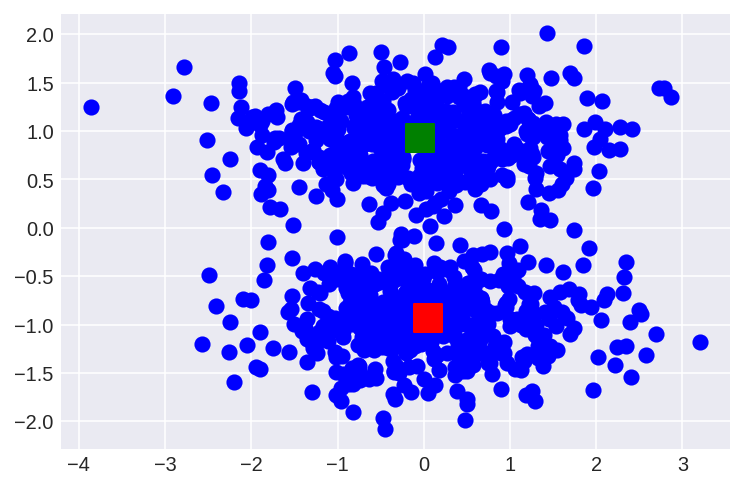

In [175]:
# Viz - 1
plt.scatter(sc_scaled_data[ : , 0], sc_scaled_data[ : , 1], s =50, c='b')
plt.scatter(-0.04349583, 0.92707635, s=200, c='g', marker='s')
plt.scatter(0.04367016, -0.93079209, s=200, c='r', marker='s')
plt.show()

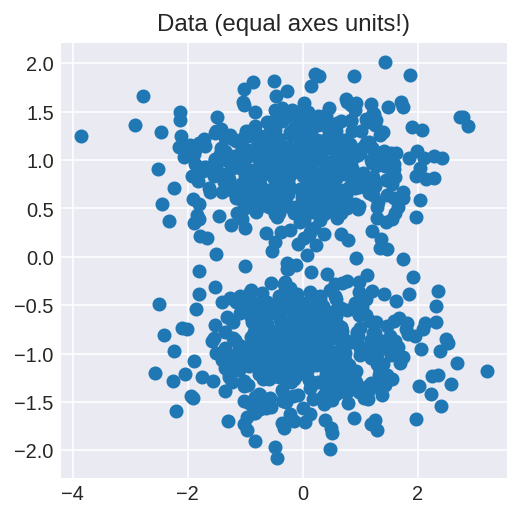

In [176]:
# Viz - 2
plot_scatter(sc_scaled_data[:, 0], sc_scaled_data[:, 1], auto_scaled=True , 
             title='Data (equal axes units!)')

We can clearly see that the example from the scaled data is more sophisticed in terms data clustering into 2 cluster.

## Exercise  3 - Preprocessing Pipeline (3 points)

In [179]:
# I'm not using this line of code! See below. 
# I've used traditional variables naming for my convenience. 
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data).

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

In [193]:
## w\o scaling
from sklearn.linear_model import LogisticRegression

# loading the dataset
wine_sklearn = load_wine(as_frame=True) # need to have sklearn => version 0.23 
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

X_train, X_test, y_train, y_test = train_test_split(wine_data, wine_labels,
                                                    test_size=0.3, random_state=42)

# model initialization
model = LogisticRegression(solver='liblinear', penalty='l1')

# fitting the model
model.fit(X_train, y_train)

# predcitions
predictions = model.predict(X_test) #y_hat

# accuracy score
model_1_score = accuracy_score(y_test, predictions)
model_1_score

0.9814814814814815

In [199]:
## with scaling
from sklearn.linear_model import LogisticRegression

# loading the dataset
wine_sklearn = load_wine(as_frame=True) # need to have sklearn => version 0.23 
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']
wine_data.astype('float64')

# Train\Test Split
X_train, X_test, y_train, y_test = train_test_split(wine_data, wine_labels, 
                                                    test_size=0.3, random_state=42)


# initializing the scaler 
sc = StandardScaler()

# fit tranform the dataset 
train_sc_scaled_data = sc.fit_transform(X_train)
test_sc_scaled_data = sc.fit_transform(X_test)


# model initialization
model_2 = LogisticRegression(solver='liblinear', penalty='l1')

# fitting the model
model_2.fit(train_sc_scaled_data, y_train)

# predcitions
predictions_2 = model_2.predict(test_sc_scaled_data) #y_hat

# accuracy score
model_2_score = accuracy_score(y_test, predictions_2)
model_2_score

0.9814814814814815

In [195]:
## with scaling
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# loading the dataset
wine_sklearn = load_wine(as_frame=True) # need to have sklearn => version 0.23 
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']
wine_data.astype('float64')

# Train\Test Split
X_train, X_test, y_train, y_test = train_test_split(wine_data, wine_labels, 
                                                    test_size=0.3, random_state=42)


# feature selection function
def select_features(X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectFromModel(RandomForestClassifier(n_estimators=25), max_features=5) #n_estimators=200

    # learn relationship from training data
    fs.fit(X_train, y_train)

    # transform train input data
    X_train_fs = fs.transform(X_train)

    # transform test input data
    X_test_fs = fs.transform(X_test)

    return X_train_fs, X_test_fs, fs

# applying feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# initializing the scaler 
sc = StandardScaler()

# fit tranform the dataset 
fs_train_sc_scaled_data = sc.fit_transform(X_train_fs)
fs_test_sc_scaled_data = sc.fit_transform(X_test_fs)


# model initialization
model_3 = LogisticRegression(solver='liblinear', penalty='l1')

# fitting the model
model_3.fit(fs_train_sc_scaled_data, y_train)

# predcitions
predictions_3 = model_3.predict(fs_test_sc_scaled_data) #y_hat

# accuracy score
model_3_score = accuracy_score(y_test, predictions_3)
model_3_score

1.0

In [196]:
model_1_score, model_2_score, model_3_score

(0.9814814814814815, 0.9814814814814815, 1.0)

In [197]:
model_1_score == model_2_score

True

LOL. Some overfitting here =). Need to investigate further. Also, I think that using Cross Validation should metigate overfitting to some degree. 
Additionally, it's quite strange that I've the same scores for w\o scaling and with scaling. 

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb


2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing


3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35


4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9


6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html


7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html


8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market

#### GPU for Catboost

In [ ]:
# GPU activating
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
# Checking the GPU
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))